In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [13]:
# 因子4：RSI背离增强的上影线因子（KUP1_RSI）
def calculate_kup1_rsi(df, rsi_window=14):
    """
    结合RSI背离的上影线因子
    公式：KUP1_RSI = (high - max(open, close)) / open * rsi_divergence
    原理：超买区的上影线更具反转意义
    """
    # 计算RSI
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    
    # 识别超买区域（RSI>70）
    overbought = np.where(df['rsi'] > 70, 1.5, 0.5)
    
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = df['high'] - max_open_close
    base_kup1 = upper_shadow / df['open']
    
    # 在超买区放大信号
    return abs(base_kup1 * overbought*df['volume'].diff())

# 因子测试

In [14]:
evaluator.set_factor(
    factor_func=calculate_kup1_rsi,
    factor_name='calculate_kup1_rsi'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.006820
   Rank_IC (Spearman): 0.010389
📊 信息比率:
   IR: 0.275836
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130535
   因子列: calculate_kup1_rsi
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


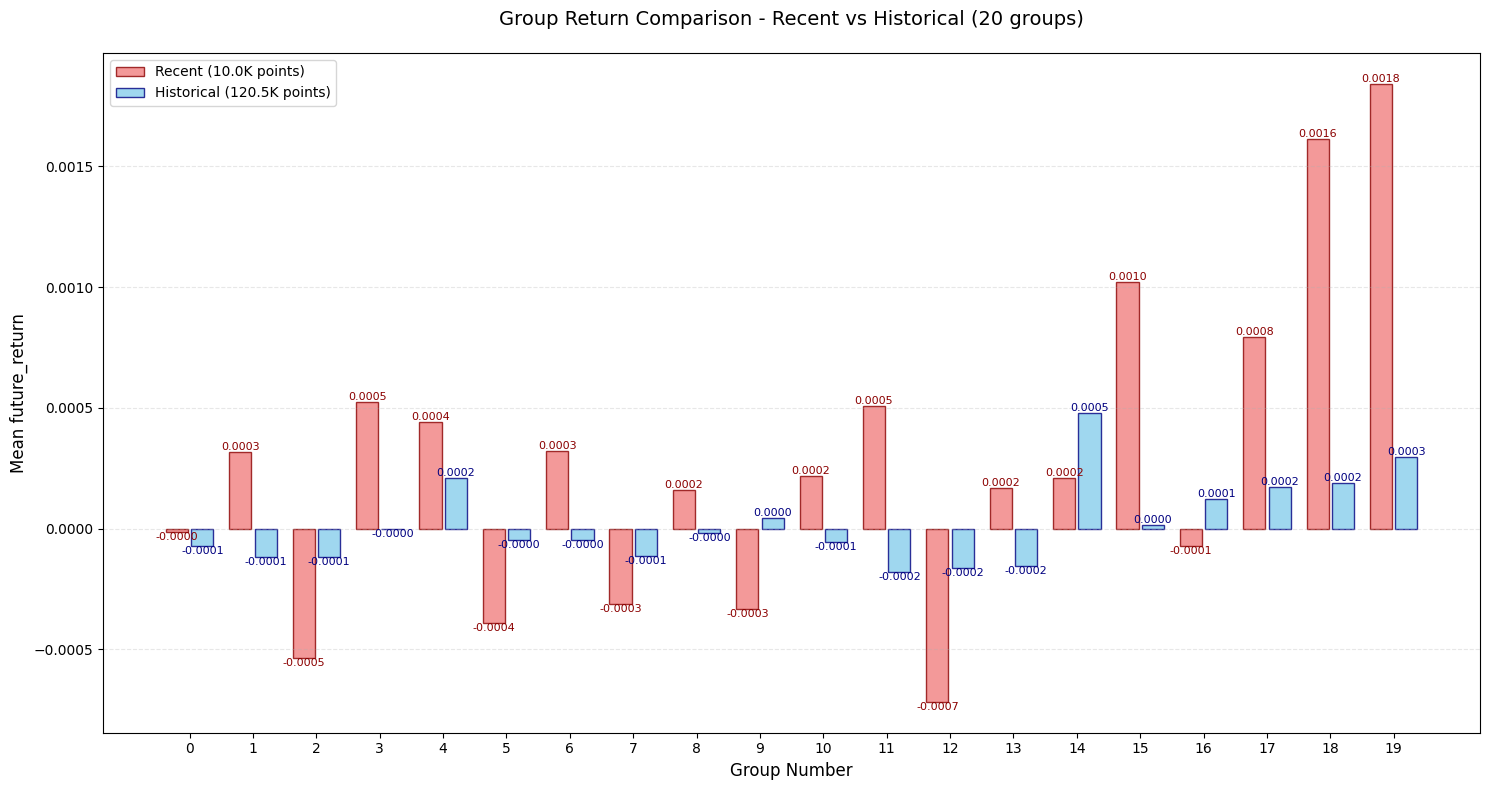

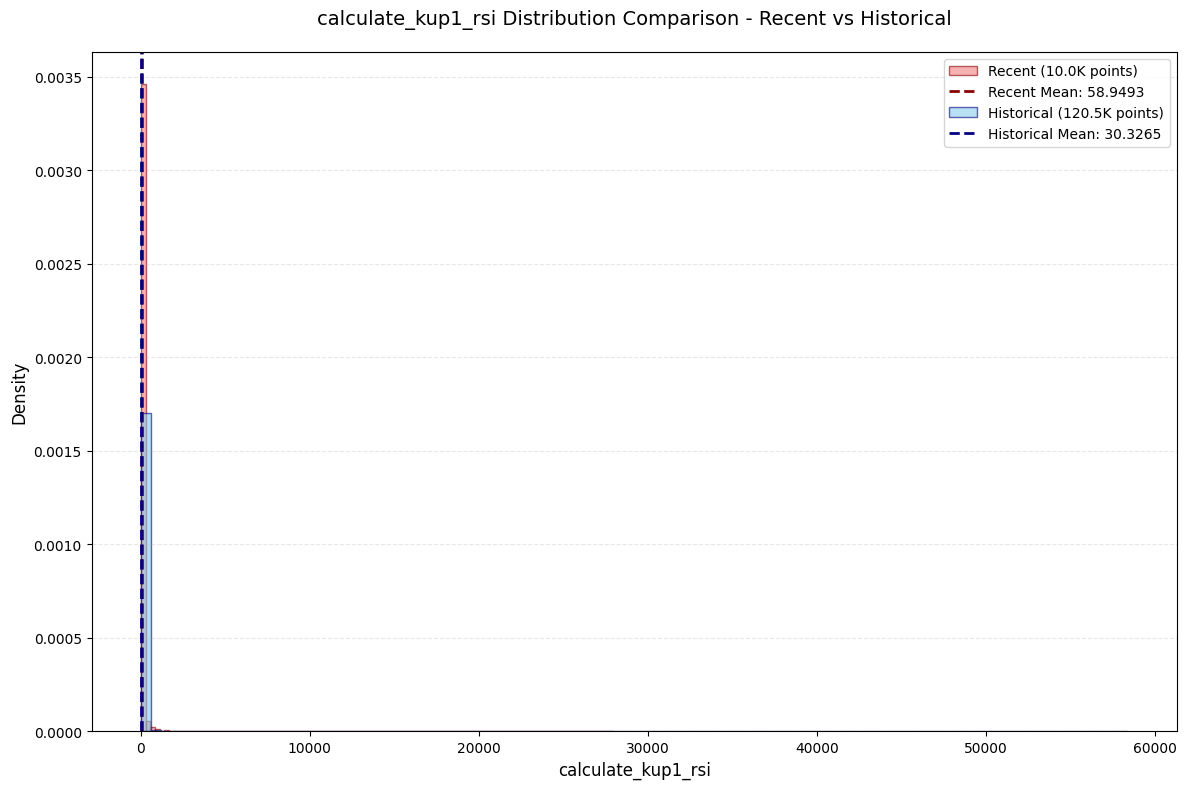

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [15]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [10]:
# 手动计算因子值并添加到数据帧
df['calculate_kup1_rsi'] = calculate_kup1_rsi(df)

# 获取因子值
factor = df['calculate_kup1_rsi']

# 筛选因子值最低的5%样本
tail_samples = df[factor < factor.quantile(0.05)].copy()

# 显示尾部样本的K线数据（前10行）
print("因子值最低的5%对应的K线数据（前10行）：")
print(tail_samples[['open', 'high', 'low', 'close', 'volume', 'taker_buy_volume', 'taker_buy_turnover']].head(10))

# 分析尾部K线特征
tail_features = tail_samples[['open', 'high', 'low', 'close', 'volume', 'taker_buy_volume', 'taker_buy_turnover']].describe()

# 计算关键指标
tail_samples['body_size'] = (tail_samples['close'] - tail_samples['open']).abs()
tail_samples['upper_shadow'] = tail_samples['high'] - np.maximum(tail_samples['open'], tail_samples['close'])
tail_samples['buy_ratio'] = tail_samples['taker_buy_volume'] / tail_samples['volume']

# 输出尾部K线特征分析
print("\n尾部K线特征分析（关键指标均值）：")
print(tail_samples[['body_size', 'upper_shadow', 'buy_ratio']].mean())

因子值最低的5%对应的K线数据（前10行）：
                         open      high       low     close     volume  \
open_time                                                                
2021-10-03 08:00:00 3392.9200 3400.5800 3389.5000 3400.5800  7069.2950   
2021-10-03 17:30:00 3419.6600 3419.6600 3403.5800 3415.3800 12428.0770   
2021-10-03 20:15:00 3465.5200 3465.5200 3450.0000 3450.7300 12978.9110   
2021-10-04 00:15:00 3415.0800 3415.0800 3405.1000 3412.0600 10665.2670   
2021-10-04 00:30:00 3412.0500 3412.0500 3381.5100 3383.7700 15858.7130   
2021-10-04 15:00:00 3319.4500 3319.4500 3268.8100 3314.2900 99631.1650   
2021-10-05 03:45:00 3383.3200 3388.6600 3380.4300 3388.6500  3622.0250   
2021-10-05 04:30:00 3385.5700 3385.5800 3371.2700 3372.5800 10673.5390   
2021-10-05 10:45:00 3445.4100 3445.4100 3427.3900 3438.5000 22876.0490   
2021-10-05 13:00:00 3454.9900 3454.9900 3435.9100 3448.7600 14077.4980   

                     taker_buy_volume  taker_buy_turnover  
open_time                   